In [7]:
import pandas as pd

# Load the dataset (assumes the CSV file is already read)
df = pd.read_csv("combined_data.csv")

# Function to fill missing values by averaging the previous and next columns
def fill_missing_with_average(df):
    for col in df.columns:
        if df[col].isna().any():
            for i in range(1, len(df) - 1):
                if pd.isna(df[col].iloc[i]):
                    prev_col = df.columns[df.columns.get_loc(col) - 1]  # Previous column
                    next_col = df.columns[df.columns.get_loc(col) + 1]  # Next column
                    # Use .loc to ensure you're working with a copy
                    df.loc[i, col] = (df.loc[i, prev_col] + df.loc[i, next_col]) / 2
    return df

df = fill_missing_with_average(df)

df.isna().sum()

df_filled = df.copy()

for col in df_filled.select_dtypes(include=['float64', 'int64']).columns:
    df_filled[col] = df_filled[col].fillna(df_filled[col].mean())
    
df_filled.isna().sum()

day                      0
vis                      0
tmp                      0
dew                      0
slp                      0
wnd_direc                0
wnd_scale                0
pm25                     0
pm10                     0
o3                       0
no2                      0
so2                      0
co                       0
AQI                      0
Determining_Pollutant    0
dtype: int64

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Assuming 'df' is the DataFrame containing your dataset

# Define the features and target variable
features = ['vis', 'tmp', 'dew', 'slp', 'wnd_direc', 'wnd_scale', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
target = 'AQI'
# Function to create data for RNN
def create_rnn_data(df, features, target, window_size=3):
    data_X = []
    data_y = []
    
    # Iterate over the rows and create sliding window of size 3
    for i in range(window_size, len(df)):
        X = df[features].iloc[i - window_size:i].values  # Last 3 days' features
        y = df[target].iloc[i]  # AQI of the current day
        data_X.append(X)
        data_y.append(y)
    
    return np.array(data_X), np.array(data_y)

# Prepare the data (features for the last 3 days to predict AQI for the current day)
X, y = create_rnn_data(df_filled, features, target, window_size=3)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


In [3]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import os

# Set the directory for TensorBoard logs
log_dir = "logs/fit"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

2024-12-15 22:13:02.925348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, activation='tanh', input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    verbose=1,
    callbacks=[tensorboard_callback]  # Add TensorBoard callback here
)

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

# Make predictions
y_pred = model.predict(X_test)

# Print first few predictions
print(f"Predictions: {y_pred[:5]}")

In [43]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
val_losses = []
val_maes = []

# Perform K-Fold Cross Validation
for train_index, val_index in kf.split(X_scaled):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Create the model
    model = create_model(input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]))

    # Train the model
    history = model.fit(
        X_train_fold, y_train_fold, 
        epochs=50, 
        batch_size=32, 
        validation_data=(X_val_fold, y_val_fold), 
        verbose=0,
        callbacks=[tensorboard_callback]
    )
    
    # Get the validation loss and MAE for the current fold
    val_loss, val_mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    
    # Store the results for this fold
    val_losses.append(val_loss)
    val_maes.append(val_mae)

In [44]:
# Calculate the mean and standard deviation of validation loss and MAE across all folds
mean_val_loss = np.mean(val_losses)
std_val_loss = np.std(val_losses)
mean_val_mae = np.mean(val_maes)
std_val_mae = np.std(val_maes)

# Output the results
print(f"Mean Validation Loss: {mean_val_loss:.4f} ± {std_val_loss:.4f}")
print(f"Mean Validation MAE: {mean_val_mae:.4f} ± {std_val_mae:.4f}")

# Evaluate the model on the final test set (if desired, use the entire data for training here)
test_loss, test_mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

Mean Validation Loss: 21006.6637 ± 1015.1147
Mean Validation MAE: 126.8533 ± 3.2246
Test Loss: 19804.3515625, Test MAE: 123.21111297607422


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
model_train = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))

history1 = model_train.fit(
    X_train, y_train, 
    epochs=50,
    batch_size=32, 
    validation_data=(X_test, y_test), 
    verbose=1
)

NotImplementedError: Cannot convert a symbolic Tensor (simple_rnn_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [51]:
y_pred = model.predict(X_scaled)
residuals = y - y_pred.flatten()
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)

# Calculate control limits
upper_control_limit = mean_residuals + 3 * std_residuals
lower_control_limit = mean_residuals - 3 * std_residuals

114/114 [==============================] - 1s 13ms/step


In [ ]:
df['day'] = pd.to_datetime(df['day'], errors='coerce')
dates = df['day'][-len(y_pred):] 

residuals_df = pd.DataFrame({
    'Date': dates,
    'Residual': residuals
})

output_file = "results/residuals_and_dates.xlsx"
residuals_df.to_excel(output_file, index=False, engine='openpyxl')
    

In [57]:
print(df['day'].head()) 

0    2014-01-01
1    2014-01-02
2    2014-01-03
3    2014-01-04
4    2014-01-05
Name: day, dtype: object


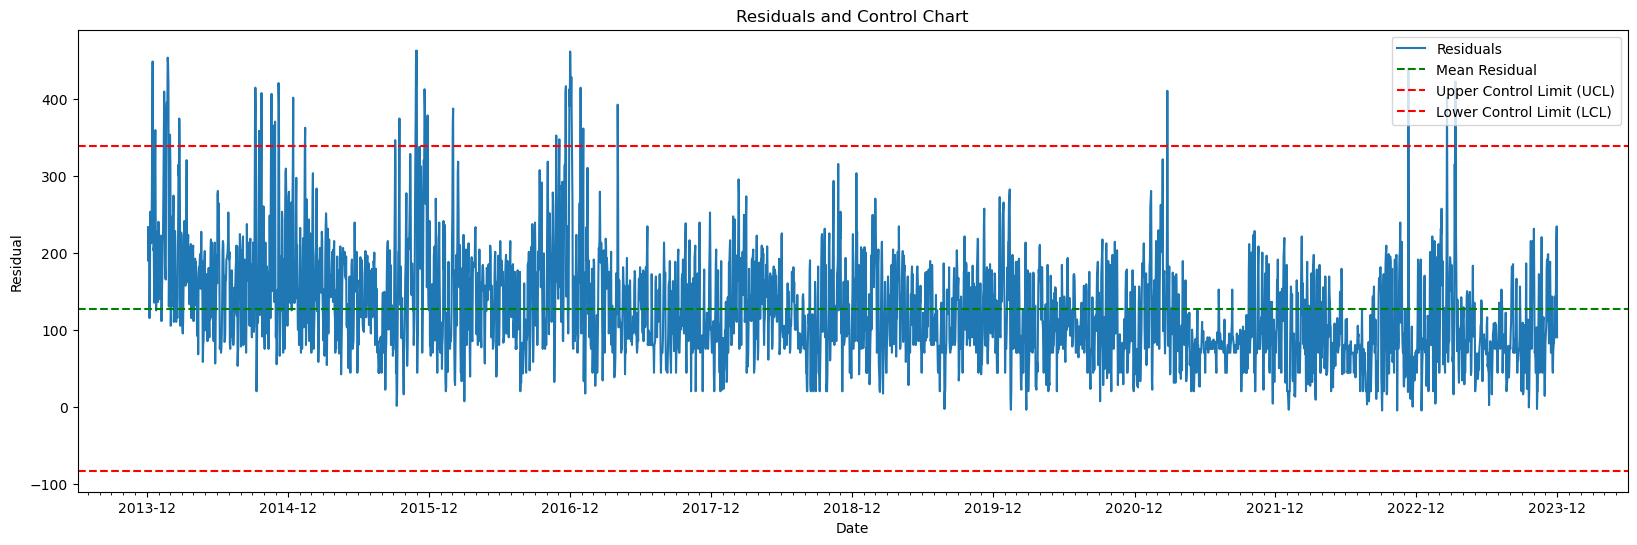

Mean Residuals: 128.01256719744816
Standard Deviation of Residuals: 70.15893270777528
Upper Control Limit (UCL): 338.489365320774
Lower Control Limit (LCL): -82.46423092587767


In [60]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df['day'] = pd.to_datetime(df['day'], errors='coerce')
dates = df['day'][-len(y_pred):] 

# Plot the residuals and control chart
plt.figure(figsize=(20, 6))
plt.plot(dates, residuals, label='Residuals')
plt.axhline(y=mean_residuals, color='green', linestyle='--', label='Mean Residual')
plt.axhline(y=upper_control_limit, color='red', linestyle='--', label='Upper Control Limit (UCL)')
plt.axhline(y=lower_control_limit, color='red', linestyle='--', label='Lower Control Limit (LCL)')
plt.title('Residuals and Control Chart')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Step 6: Set x-ticks to only show the beginning of each year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Place a tick at the beginning of each year
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend(loc='upper right')
plt.show()

# Print the control limits for reference
print(f'Mean Residuals: {mean_residuals}')
print(f'Standard Deviation of Residuals: {std_residuals}')
print(f'Upper Control Limit (UCL): {upper_control_limit}')
print(f'Lower Control Limit (LCL): {lower_control_limit}')